In [17]:
from ppsim import species, Simulation, Specie
import numpy as np
from matplotlib import pyplot as plt

In [25]:
def gen_string(prefix: str, n: int) -> str:
    to_return = ""
    for i in range(n):
        to_return += prefix + str(i) + " "
    return to_return[:-1]

In [180]:
def board(sim: Simulation) -> str:
    # return board state
    states = np.zeros((3,3), dtype=str)
    for i in range(9):
        if Specie(name=f'o{i}') in sim.config_dict.keys():
            states[i // 3, i % 3] = 'o'
        elif Specie(name=f'x{i}') in sim.config_dict.keys():
            states[i // 3, i % 3] = 'x'
        else:
            states[i // 3, i % 3] = '_'
    return states

In [144]:
# set up move marker (c, h), waste molecule (w)
c, h, w = species("c h w")
# toggle clean up on, clean up off
cuon, cuoff = species("cuon cuoff")
# blank squares
b = species(gen_string("b", 9))
# option, try squares (this computes probabilities)
opt = species(gen_string("opt", 9))
t = species(gen_string("t", 9))
# filled squares
x = species(gen_string("x", 9))
o = species(gen_string("o", 9))
# track move that was made
m = species(gen_string("m", 9))
# inject a move: human's turn, produces mh to make human move
inject = species(gen_string("i", 9))
mh = species(gen_string("mh", 9))

In [226]:
rules = []
# set up rules
for i in range(9):
    # generate random move from blank squares - this is the logic we want to start changing
    rules.append(w + c >> c + opt[i])
    rules.append(opt[i] + b[i] >> t[i] + b[i])

    # make_move: requires a blank square and the move marker -> fills square and records move
    rules.append(t[i] + c >> o[i] + m[i])
    # move recorded -> decompose blank, generate human's turn
    rules.append(m[i] + b[i] >> w + h)

    # if human's turn, do the same thing:
    rules.append(inject[i] + h >> x[i] + mh[i])
    rules.append(mh[i] + b[i] >> w + c)

    # clean up step, and toggle off of clean up
    rules.append(cuon + opt[i] >> cuon + w)
    rules.append(cuon + t[i] >> cuon + w)
    rules.append(cuoff + cuon >> w + w)

In [254]:
init_config = {}
init_config[w] = 100 # surplus waste - I think this actually ends up affecting the probabilities
init_config[c] = 0 # crn's move
init_config[h] = 1 # not human's move
init_config[cuon] = 0 # add to clean up
init_config[cuoff] = 0 # add to stop cleaning up
move_probabilities = [0, 0, 0, 0, 0, 0, 0, 0, 0] # t values
for i in range(9):
    init_config[b[i]] = 1 # all squares set to blank
    init_config[x[i]] = 0
    init_config[o[i]] = 0
    init_config[m[i]] = 0
    init_config[mh[i]] = 0
    init_config[inject[i]] = 0
    init_config[opt[i]] = 0
    init_config[t[i]] = move_probabilities[i]

In [212]:
# -1 for cuon, -2 for cuoff, 0 through 8 for corresponding move
def injection(n: int, init_config: dict) -> dict:
    if n == -1:
        init_config[cuon] = 1
    elif n == -2:
        init_config[cuoff] = 1
    else:
        init_config[inject[n]] = 1
    return init_config

In [227]:
def play_turn(n: int) -> Simulation:
    sim = Simulation(injection(-1, init_config), rules)
    sim.run()
    print(board(sim))
    sim = Simulation(injection(-2, sim.config_dict), rules)
    sim.run()
    print(board(sim))
    sim = Simulation(injection(n, sim.config_dict), rules)
    sim.run()
    print(board(sim))
    return sim

In [261]:
sim = play_turn(4) # n determines the move human plays (as of now, player X)

[['_' '_' '_']
 ['_' '_' '_']
 ['_' '_' '_']]


[['_' '_' '_']
 ['_' '_' '_']
 ['_' '_' '_']]


[['_' '_' '_']
 ['_' 'x' '_']
 ['_' 'o' '_']]


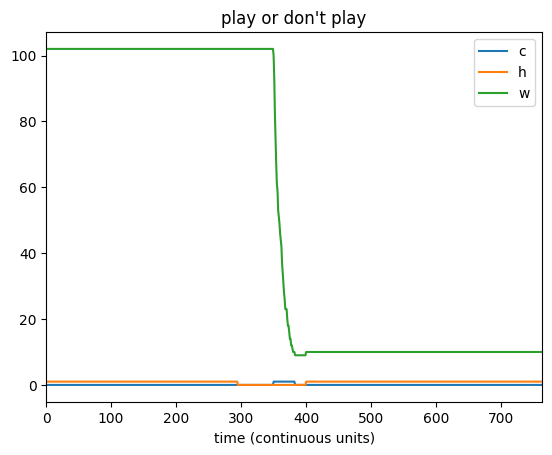

In [262]:
# plot results
sim.history[['c','h','w']].plot()
plt.title("play or don't play")
plt.xlim(0, sim.times[-1])
plt.show()